In [1]:
import tensorflow as tf
import numpy as np
import deepchem as dc

from deepchem.models.tensorgraph.layers import Feature
from deepchem.models.tensorgraph.layers import Dense, GraphConv, BatchNorm
from deepchem.models.tensorgraph.layers import GraphPool, GraphGather
from deepchem.models.tensorgraph.layers import Dense, SoftMax, SoftMaxCrossEntropy, WeightedError, Stack
from deepchem.models.tensorgraph.layers import Label, Weights
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

from deepchem.models.tensorgraph.tensor_graph import TensorGraph
tg = TensorGraph(use_queue=False)

/home/baseline/.conda/envs/test/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
atom_features = Feature(shape=(None, 75))
degree_slice = Feature(shape=(None, 2), dtype=tf.int32)
membership = Feature(shape=(None,), dtype=tf.int32)

deg_adjs = []
for i in range(0, 10 + 1):
    deg_adj = Feature(shape=(None, i + 1), dtype=tf.int32)
    deg_adjs.append(deg_adj)

In [3]:
batch_size = 50

gc1 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[atom_features, degree_slice, membership] + deg_adjs)
batch_norm1 = BatchNorm(in_layers=[gc1])
gp1 = GraphPool(in_layers=[batch_norm1, degree_slice, membership] + deg_adjs)
gc2 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm2 = BatchNorm(in_layers=[gc2])
gp2 = GraphPool(in_layers=[batch_norm2, degree_slice, membership] + deg_adjs)
dense = Dense(out_channels=128, activation_fn=tf.nn.relu, in_layers=[gp2])
batch_norm3 = BatchNorm(in_layers=[dense])
readout = GraphGather(
    batch_size=batch_size,
    activation_fn=tf.nn.tanh,
    in_layers=[batch_norm3, degree_slice, membership] + deg_adjs)

In [4]:
costs = []
labels = []
tasks = ['classification']
for task in range(len(tasks)):
    classification = Dense(
        out_channels=2, activation_fn=None, in_layers=[readout])

    softmax = SoftMax(in_layers=[classification])
    tg.add_output(softmax)

    label = Label(shape=(None, 2))
    labels.append(label)
    cost = SoftMaxCrossEntropy(in_layers=[label, classification])
    costs.append(cost)
all_cost = Stack(in_layers=costs, axis=1)
weights = Weights(shape=(None, len(tasks)))
loss = WeightedError(in_layers=[all_cost, weights])
tg.set_loss(loss)

In [5]:
def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
    for epoch in range(epochs):
        if not predict:
            print('Starting epoch %i' % epoch)
        for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(
                                        batch_size, pad_batches=pad_batches, deterministic=True)):
            d = {}
            for index, label in enumerate(labels):
                d[label] = to_one_hot(y_b[:, index])
            d[weights] = w_b
            multiConvMol = ConvMol.agglomerate_mols(X_b)
            d[atom_features] = multiConvMol.get_atom_features()
            d[degree_slice] = multiConvMol.deg_slice
            d[membership] = multiConvMol.membership
            for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
                d[deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
            yield d

In [6]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

def reshape_y_pred(y_true, y_pred):
    """
    TensorGraph.Predict returns a list of arrays, one for each output
    We also have to remove the padding on the last batch
    Metrics taks results of shape (samples, n_task, prob_of_class)
    """
    n_samples = len(y_true)
    retval = np.stack(y_pred, axis=1)
    return retval[:n_samples]

num_models = 10
rocauc_train = []
rocauc_valid = []
rocauc_test = []
for i in range(num_models):
    bace_tasks, bace_datasets, transformers = dc.molnet.load_bace_classification(featurizer='GraphConv',split='random')
    train_dataset, valid_dataset, test_dataset = bace_datasets

    tg.fit_generator(data_generator(train_dataset, epochs=1))

    print("Evaluating model", i)
    train_predictions = np.expand_dims(tg.predict_on_generator(data_generator(train_dataset, predict=True)), axis=0)
    train_predictions = reshape_y_pred(train_dataset.y, train_predictions)
    train_scores = metric.compute_metric(train_dataset.y, train_predictions, train_dataset.w)
    rocauc_train.append(train_scores)
    print("Training ROC-AUC Score: %f" % train_scores)

    valid_predictions = np.expand_dims(tg.predict_on_generator(data_generator(valid_dataset, predict=True)), axis=0)
    valid_predictions = reshape_y_pred(valid_dataset.y, valid_predictions)
    valid_scores = metric.compute_metric(valid_dataset.y, valid_predictions, valid_dataset.w)
    rocauc_valid.append(valid_scores)
    print("Valid ROC-AUC Score: %f" % valid_scores)
    
    test_predictions = np.expand_dims(tg.predict_on_generator(data_generator(test_dataset, predict=True)), axis=0)
    test_predictions = reshape_y_pred(test_dataset.y, test_predictions)
    test_scores = metric.compute_metric(test_dataset.y, test_predictions, test_dataset.w)
    rocauc_test.append(test_scores)
    print("test ROC-AUC Score: %f" % test_scores)    

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


/home/baseline/.conda/envs/test/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Starting epoch 0
Evaluating model 0
computed_metrics: [0.5784649111908134]
Training ROC-AUC Score: 0.578465
computed_metrics: [0.6164293248945147]
Valid ROC-AUC Score: 0.616429
computed_metrics: [0.5573060941828254]
test ROC-AUC Score: 0.557306
Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.
Starting epoch 0
Evaluating model 1
computed_metrics: [0.6469776161642935]
Training ROC-AUC Score: 0.646978
computed_metrics: [0.676951476793249]
Valid ROC-AUC Score: 0.676951
computed_metrics: [0.6293282548476454]
test ROC-AUC Score: 0.629328
Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.
Starting epoch 0
Evaluating model 2
computed_metrics: [0.6698867417120169]
Training ROC-AUC Score: 0.669887
computed_metrics: [0.6913238396624473]
Valid ROC-AUC Score: 0.691324
computed_metrics: [0.6237880886426593]
test ROC-AUC Score: 0.623788
Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.
Starting epoch 0
Evalua

In [7]:
values = []
values.append(np.mean(rocauc_train))
values.append(np.mean(rocauc_valid))
values.append(np.mean(rocauc_test))
stds = []
stds.append(np.std(rocauc_train))
stds.append(np.std(rocauc_valid))
stds.append(np.std(rocauc_test))

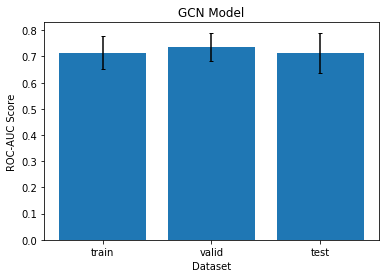

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
topics = ['train', 'valid', 'test']
plt.bar(topics, values, yerr=stds, capsize=2)

plt.title('GCN Model')
plt.xlabel('Dataset')
plt.ylabel('ROC-AUC Score')
plt.show()